# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [131]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pynektools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [132]:
# Data types
from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.coef import Coef
from pynektools.datatypes.field import Field, FieldRegistry

# Readers
from pynektools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pynektools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '/home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001'

## Read the data

In [133]:
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)

pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)


for e in range(msh.nelv):
    if (np.min(msh.x[e]), np.max(msh.x[e])) == (0, 0.25):
        if (np.min(msh.y[e]), np.max(msh.y[e])) == (0, 1.1399999856948853):
            print(e)
    
coef = Coef(msh=msh, comm=comm)

2025-02-19 16:16:45,274 - Mesh - INFO - Initializing empty Mesh object.
2025-02-19 16:16:45,276 - Field - INFO - Initializing empty Field object
2025-02-19 16:16:45,276 - pynekread - INFO - Reading file: /home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001
2025-02-19 16:16:45,279 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-19 16:16:45,280 - Mesh - INFO - Initializing common attributes.
2025-02-19 16:16:45,281 - Mesh - INFO - Getting vertices
2025-02-19 16:16:45,282 - Mesh - INFO - Getting edge centers
2025-02-19 16:16:45,289 - Mesh - INFO - Facet centers not available for 2D
2025-02-19 16:16:45,290 - Mesh - INFO - Mesh object initialized.
2025-02-19 16:16:45,290 - Mesh - INFO - Mesh data is of type: float64
2025-02-19 16:16:45,291 - Mesh - INFO - Elapsed time: 0.011444424000046638s
2025-02-19 16:16:45,291 - pynekread - INFO - Reading field data
2025-02-19 16:16:45,294 - pynekread - INFO - File read
2025-02-19 16:16:45,295 - pynekread - INF

## Initialize the Direct sampler

In [134]:
from pynektools.compression.gpc_direct_sampling import DirectSampler

ds = DirectSampler(comm=comm, msh=msh, coef=coef, field=fld.registry['u'])

2025-02-19 16:16:45,351 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-19 16:16:45,360 - DirectSampler - INFO - Filling array with linear coordinate per point in the elements


In [ ]:
ds.estimate_covariance("average", elements_to_average=100)
ds.sample(method="fixed_bitrate", n_samples=63)


2025-02-19 16:16:45,387 - DirectSampler - INFO - Estimating the covariance matrix using the averaging method method. Averaging over 50 elements at a time
2025-02-19 16:16:45,389 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. Sampling 63 modes


In [136]:
ind_50 = np.where(ds.field_sampled[0] == -50)
#print(ds.field[0])
#print(ds.field_sampled[0])
a = abs(ds.field_sampled[0])-abs(ds.field[0])
a[ind_50] = -50
print(a)

[[[  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0. -50.   0.   0.   0.   0.   0.   0.]]]


In [137]:

print(ds.field_hat[1466].reshape(-1,1, order='F'))

print("======")

print(ds.field_sampled[1466].reshape(-1,1, order='F'))

[[ 1.99990441e-01]
 [-5.57531503e-06]
 [-1.80462288e-08]
 [ 7.00211732e-09]
 [-9.51879178e-09]
 [ 2.13566155e-09]
 [-5.95115817e-10]
 [-5.36121616e-10]
 [-8.59488645e-06]
 [-5.00078505e-06]
 [-3.83074439e-09]
 [ 8.52690949e-09]
 [-8.40598942e-09]
 [ 2.39046847e-09]
 [-8.58811016e-10]
 [-2.42388614e-10]
 [-2.37776126e-06]
 [-1.36844321e-06]
 [ 1.57842481e-08]
 [ 5.69112633e-09]
 [-2.72724125e-09]
 [ 4.27633113e-10]
 [-4.92429909e-10]
 [ 4.96550225e-10]
 [ 1.13080070e-07]
 [ 7.57060759e-08]
 [ 1.00539981e-08]
 [ 8.09318145e-10]
 [-2.86645941e-10]
 [ 2.32829433e-10]
 [ 1.42264199e-10]
 [ 4.43830162e-10]
 [ 8.43976818e-08]
 [ 4.96585829e-08]
 [-1.09479314e-09]
 [ 8.54305353e-10]
 [ 9.55948182e-10]
 [-8.39331422e-10]
 [ 3.69644683e-10]
 [ 2.50419075e-10]
 [-1.66313403e-08]
 [-1.06633414e-08]
 [-2.55425789e-09]
 [-9.41682210e-11]
 [ 1.41116511e-09]
 [-6.89430439e-10]
 [ 6.21008604e-11]
 [ 1.17915297e-09]
 [-4.47323203e-09]
 [-2.63863014e-09]
 [-1.17943747e-09]
 [-1.12387309e-09]
 [ 1.3693124

In [138]:
recon = ds.predict(ds.field_sampled)

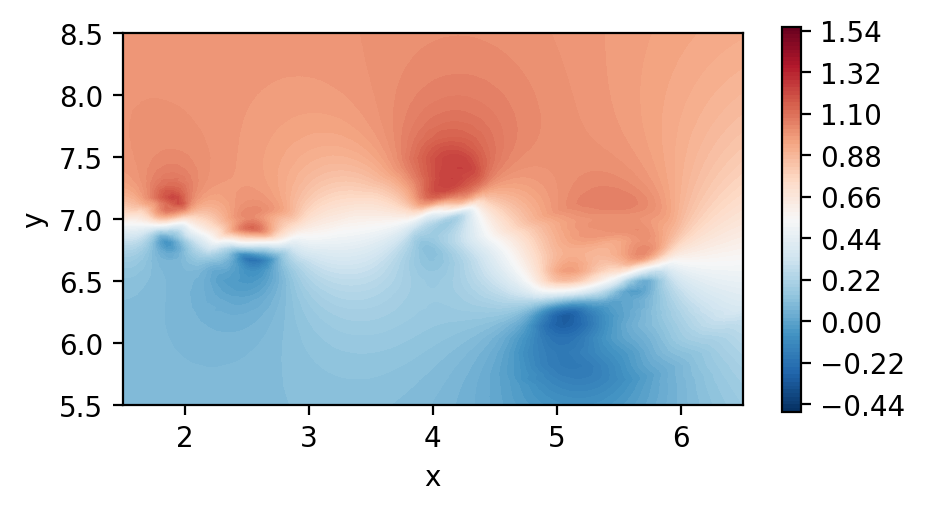

In [139]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

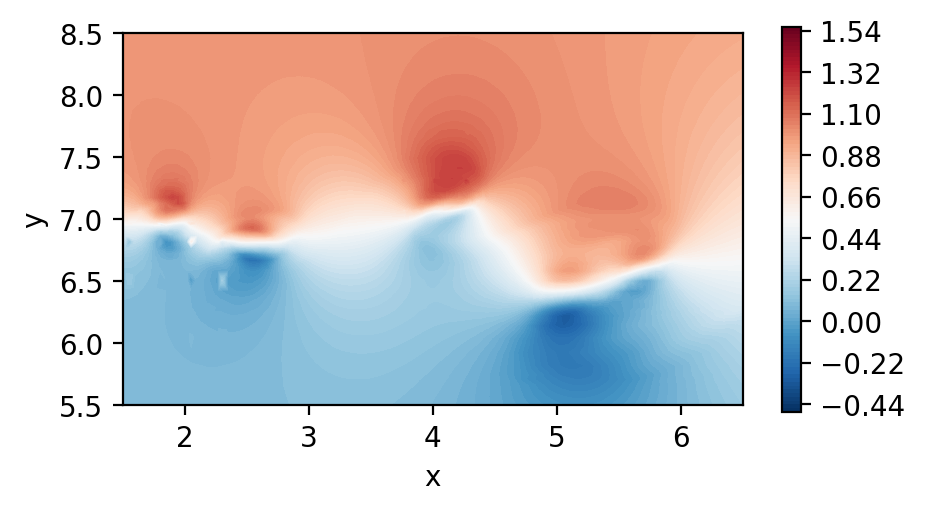

In [140]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

In [141]:
print(np.mean(fld.registry["u"] - recon))

-3.2732643739729756e-08
